<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting boiling points of elemental substances

## Imports and Installs

In [ ]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-dhgs8w9t
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-dhgs8w9t
  Resolved https://github.com/pydata/xarray.git to commit 326dbe78d7ea887c2c242e811b7973661137617f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.2.dev31+g326dbe78-py3-none-any.whl size=1247997 sha256=a28f6ce533d17d9645aa028d0321add7ecb432e6d3fc532d60d4ce545f9838b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s5tq6i_/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1


In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
import arviz as az
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods
import urllib.request #Using advice from stack exchange
import bambi as bmb

## Getting Data

Like usual, I wrote and preprocessed my data in a seperate local file since I found that alot easier to do and then I can upload my cleaned up data to github, which means less time redoing work down the line.

In [ ]:
url = 'https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/refs/heads/main/atomsrepr.txt'
data = eval(urllib.request.urlopen(url).read())

Preprocessing code was this
```
atoms = []
with open('atoms.txt', 'r') as f:
    txt = f.read()

for line in txt.split('\n'):
    try:
        n = int(line)
        atoms.append([n])
    except:
        if len(line) <= 2:
            atoms[-1].append(line)
        elif '\t' in line:
            lbl, val = line.split('\t')
            if ' ' in val:
                val = val.split(' ')
            atoms[-1].append((lbl, val))

cats = {'Metaloids':'BSiGeAsSbTePo',
        'Nobel Gases': 'HeNeArKrXeRnOg',
        'Diatomics': 'NOFClBrIH',
        'Alkali': 'LiBeNaMgKCaRbSrCsBaFrRa',
        'Non-Metals': 'CPSSeAtTs'}

atdat = {}
for atom in atoms:
    i = atom[0]
    name = atom[1]
    atdat[name] = {'Num': i}
    for k, v in atom[2:]:
        atdat[name][k] = v
    for cat, val in cats.items():
        if name in val:
            atdat[name]['Type'] = cat
            break
    else:
        atdat[name]['Type'] = 'Metals'

props = {'Type': 'Ty', 'Density': 'p', 'Atomic Mass': 'M', 'Atomic Radius (van der Waals)': 'r', 'Ionization Energy': 'IE', 'Boiling Point': 'BP'}

atdatf = {}
units = {}
for name in atdat:
    atdatf[name] = {}
    for prop in props:
        if prop not in atdat[name]:
            print(f'Cannot find {prop} in {name}')
            del atdatf[name]
            break
        v = atdat[name][prop]
        if type(v) == list:
            v, u = v
            units[props[prop]] = u
        try:
            v = float(v)
        except:
            pass
        atdatf[name][props[prop]] = v
```

The effective result of preprocessing my data was extracting all of the properties of elements into a table and then selecting only the elements which have all of the properties to be exported (Dont want NaN's everywhere)

In [ ]:
data

{'H': {'Ty': 'Diatomics',
  'p': 8.988e-05,
  'M': 1.008,
  'r': 120.0,
  'IE': 13.598,
  'BP': 20.28},
 'He': {'Ty': 'Nobel Gases',
  'p': 0.0001785,
  'M': 4.0026,
  'r': 140.0,
  'IE': 24.587,
  'BP': 4.22},
 'Li': {'Ty': 'Alkali',
  'p': 0.534,
  'M': 7.0,
  'r': 182.0,
  'IE': 5.392,
  'BP': 1615.0},
 'Be': {'Ty': 'Alkali',
  'p': 1.85,
  'M': 9.012183,
  'r': 153.0,
  'IE': 9.323,
  'BP': 2744.0},
 'B': {'Ty': 'Metaloids',
  'p': 2.37,
  'M': 10.81,
  'r': 192.0,
  'IE': 8.298,
  'BP': 4273.0},
 'C': {'Ty': 'Non-Metals',
  'p': 2.267,
  'M': 12.011,
  'r': 170.0,
  'IE': 11.26,
  'BP': 4098.0},
 'N': {'Ty': 'Diatomics',
  'p': 0.0012506,
  'M': 14.007,
  'r': 155.0,
  'IE': 14.534,
  'BP': 77.36},
 'O': {'Ty': 'Diatomics',
  'p': 0.001429,
  'M': 15.999,
  'r': 152.0,
  'IE': 13.618,
  'BP': 90.2},
 'F': {'Ty': 'Diatomics',
  'p': 0.001696,
  'M': 18.99840316,
  'r': 135.0,
  'IE': 17.423,
  'BP': 85.03},
 'Ne': {'Ty': 'Nobel Gases',
  'p': 0.0008999,
  'M': 20.18,
  'r': 154.0,


Now I'll just change it from a dictionary to a list of dicts as this will be easier to turn into a dataframe

In [ ]:
ndata = []
for key, data in data.items():
  ndata.append({'Sym': key})
  ndata[-1].update(data)

In [ ]:
ndata

[{'Sym': 'H',
  'Ty': 'Diatomics',
  'p': 8.988e-05,
  'M': 1.008,
  'r': 120.0,
  'IE': 13.598,
  'BP': 20.28},
 {'Sym': 'He',
  'Ty': 'Nobel Gases',
  'p': 0.0001785,
  'M': 4.0026,
  'r': 140.0,
  'IE': 24.587,
  'BP': 4.22},
 {'Sym': 'Li',
  'Ty': 'Alkali',
  'p': 0.534,
  'M': 7.0,
  'r': 182.0,
  'IE': 5.392,
  'BP': 1615.0},
 {'Sym': 'Be',
  'Ty': 'Alkali',
  'p': 1.85,
  'M': 9.012183,
  'r': 153.0,
  'IE': 9.323,
  'BP': 2744.0},
 {'Sym': 'B',
  'Ty': 'Metaloids',
  'p': 2.37,
  'M': 10.81,
  'r': 192.0,
  'IE': 8.298,
  'BP': 4273.0},
 {'Sym': 'C',
  'Ty': 'Non-Metals',
  'p': 2.267,
  'M': 12.011,
  'r': 170.0,
  'IE': 11.26,
  'BP': 4098.0},
 {'Sym': 'N',
  'Ty': 'Diatomics',
  'p': 0.0012506,
  'M': 14.007,
  'r': 155.0,
  'IE': 14.534,
  'BP': 77.36},
 {'Sym': 'O',
  'Ty': 'Diatomics',
  'p': 0.001429,
  'M': 15.999,
  'r': 152.0,
  'IE': 13.618,
  'BP': 90.2},
 {'Sym': 'F',
  'Ty': 'Diatomics',
  'p': 0.001696,
  'M': 18.99840316,
  'r': 135.0,
  'IE': 17.423,
  'BP': 85

In [ ]:
frame = pd.DataFrame(ndata)  #Put it into a frame for usage later
frame

Sym           Ty          p           M      r      IE       BP
0    H    Diatomics   0.000090    1.008000  120.0  13.598    20.28
1   He  Nobel Gases   0.000179    4.002600  140.0  24.587     4.22
2   Li       Alkali   0.534000    7.000000  182.0   5.392  1615.00
3   Be       Alkali   1.850000    9.012183  153.0   9.323  2744.00
4    B    Metaloids   2.370000   10.810000  192.0   8.298  4273.00
..  ..          ...        ...         ...    ...     ...      ...
88   U       Metals  18.950000  238.028900  240.0   6.194  4404.00
89  Np       Metals  20.250000  237.048172  221.0   6.266  4175.00
90  Pu       Metals  19.840000  244.064200  243.0   6.060  3501.00
91  Am       Metals  13.690000  243.061380  244.0   5.993  2284.00
92  Cm       Metals  13.510000  247.070350  245.0   6.020  3400.00

[93 rows x 7 columns]

## Info

Lets plot it to see if theres anything meaningfull.

<Axes: xlabel='Ty', ylabel='BP'>

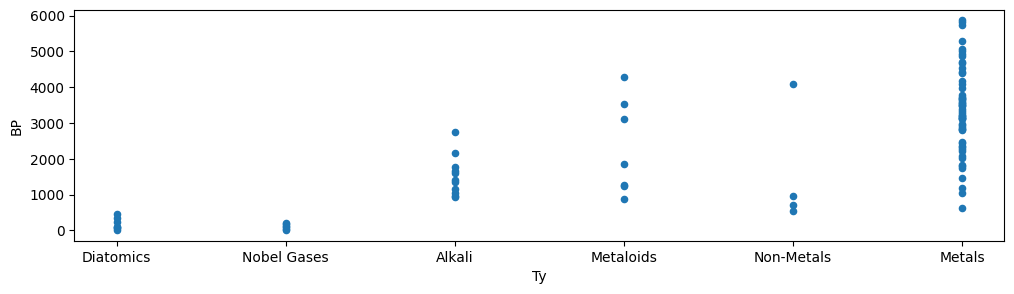

In [ ]:
frame.plot(x="Ty", y="BP", figsize=(12, 3), kind="scatter")

This is a good sign, just based on type we can see noteable trends in the Boiling Points of elements based on their classifications. Obiviously some groups are rather sparse, but they seem to be different enough that I think they warrant distinct labels.

What is of note is the split in the Metals, but I didnt look further into this, even tho I definately should have.

In [ ]:
[k['Sym'] for k in ndata if k['Ty']=='Non-Metals']

['C', 'P', 'S', 'Se']

In [ ]:
[k['Sym'] for k in ndata if k['Ty']=='Metaloids']

['B', 'Si', 'Ge', 'As', 'Sb', 'Te', 'Po']

These groups are rather sparse and this might cause a few issues, but I'm betting on these groups being useful.

## Models

For my first model I'm going to use this model below. Technically I should have started with just my predictors and no interaction terms, but as I'll show later I was right in guessing that would do worse.

My initial reasoning for the interactions between radius and mass and mass and density was that I suspected mass influenced them and the Boiling Point itself, so the interaction felt important.

I did however make a mistake and forget my ` + M` term, which is annoying

In [ ]:
model_1 = mod = bmb.Model("BP ~ p + r + IE + Ty + r:M +p:M", frame)
dat_1 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_1

       Formula: BP ~ p + r + IE + Ty + r:M +p:M
        Family: gaussian
          Link: mu = identity
  Observations: 93
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2536.2125, sigma: 26783.9186)
            p ~ Normal(mu: 0.0, sigma: 675.4708)
            r ~ Normal(mu: 0.0, sigma: 109.5396)
            IE ~ Normal(mu: 0.0, sigma: 1155.8335)
            Ty ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [14970.6279 14970.6279  8152.4894 16076.9259 19467.638
                ])
            r:M ~ Normal(mu: 0.0, sigma: 0.2313)
            p:M ~ Normal(mu: 0.0, sigma: 3.0419)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1579.848)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

As we can see by looking at Bambi's choice of priors is that its using alot of normals, this makes sense, and gien that I didnt specify anything else, this is reasonable. Also note worthy is that since I dont know the underlying process or relations, I cannot say what would be a better family than a gaussian, I dont have a degree in quantum chromodynamics and molecular systems (yet)

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'IE'}>,
        <Axes: title={'center': 'Ty\nDiatomics'}>],
       [<Axes: title={'center': 'Ty\nMetaloids'}>,
        <Axes: title={'center': 'Ty\nMetals'}>,
        <Axes: title={'center': 'Ty\nNobel Gases'}>],
       [<Axes: title={'center': 'Ty\nNon-Metals'}>,
        <Axes: title={'center': 'r:M'}>, <Axes: title={'center': 'p:M'}>]],
      dtype=object)

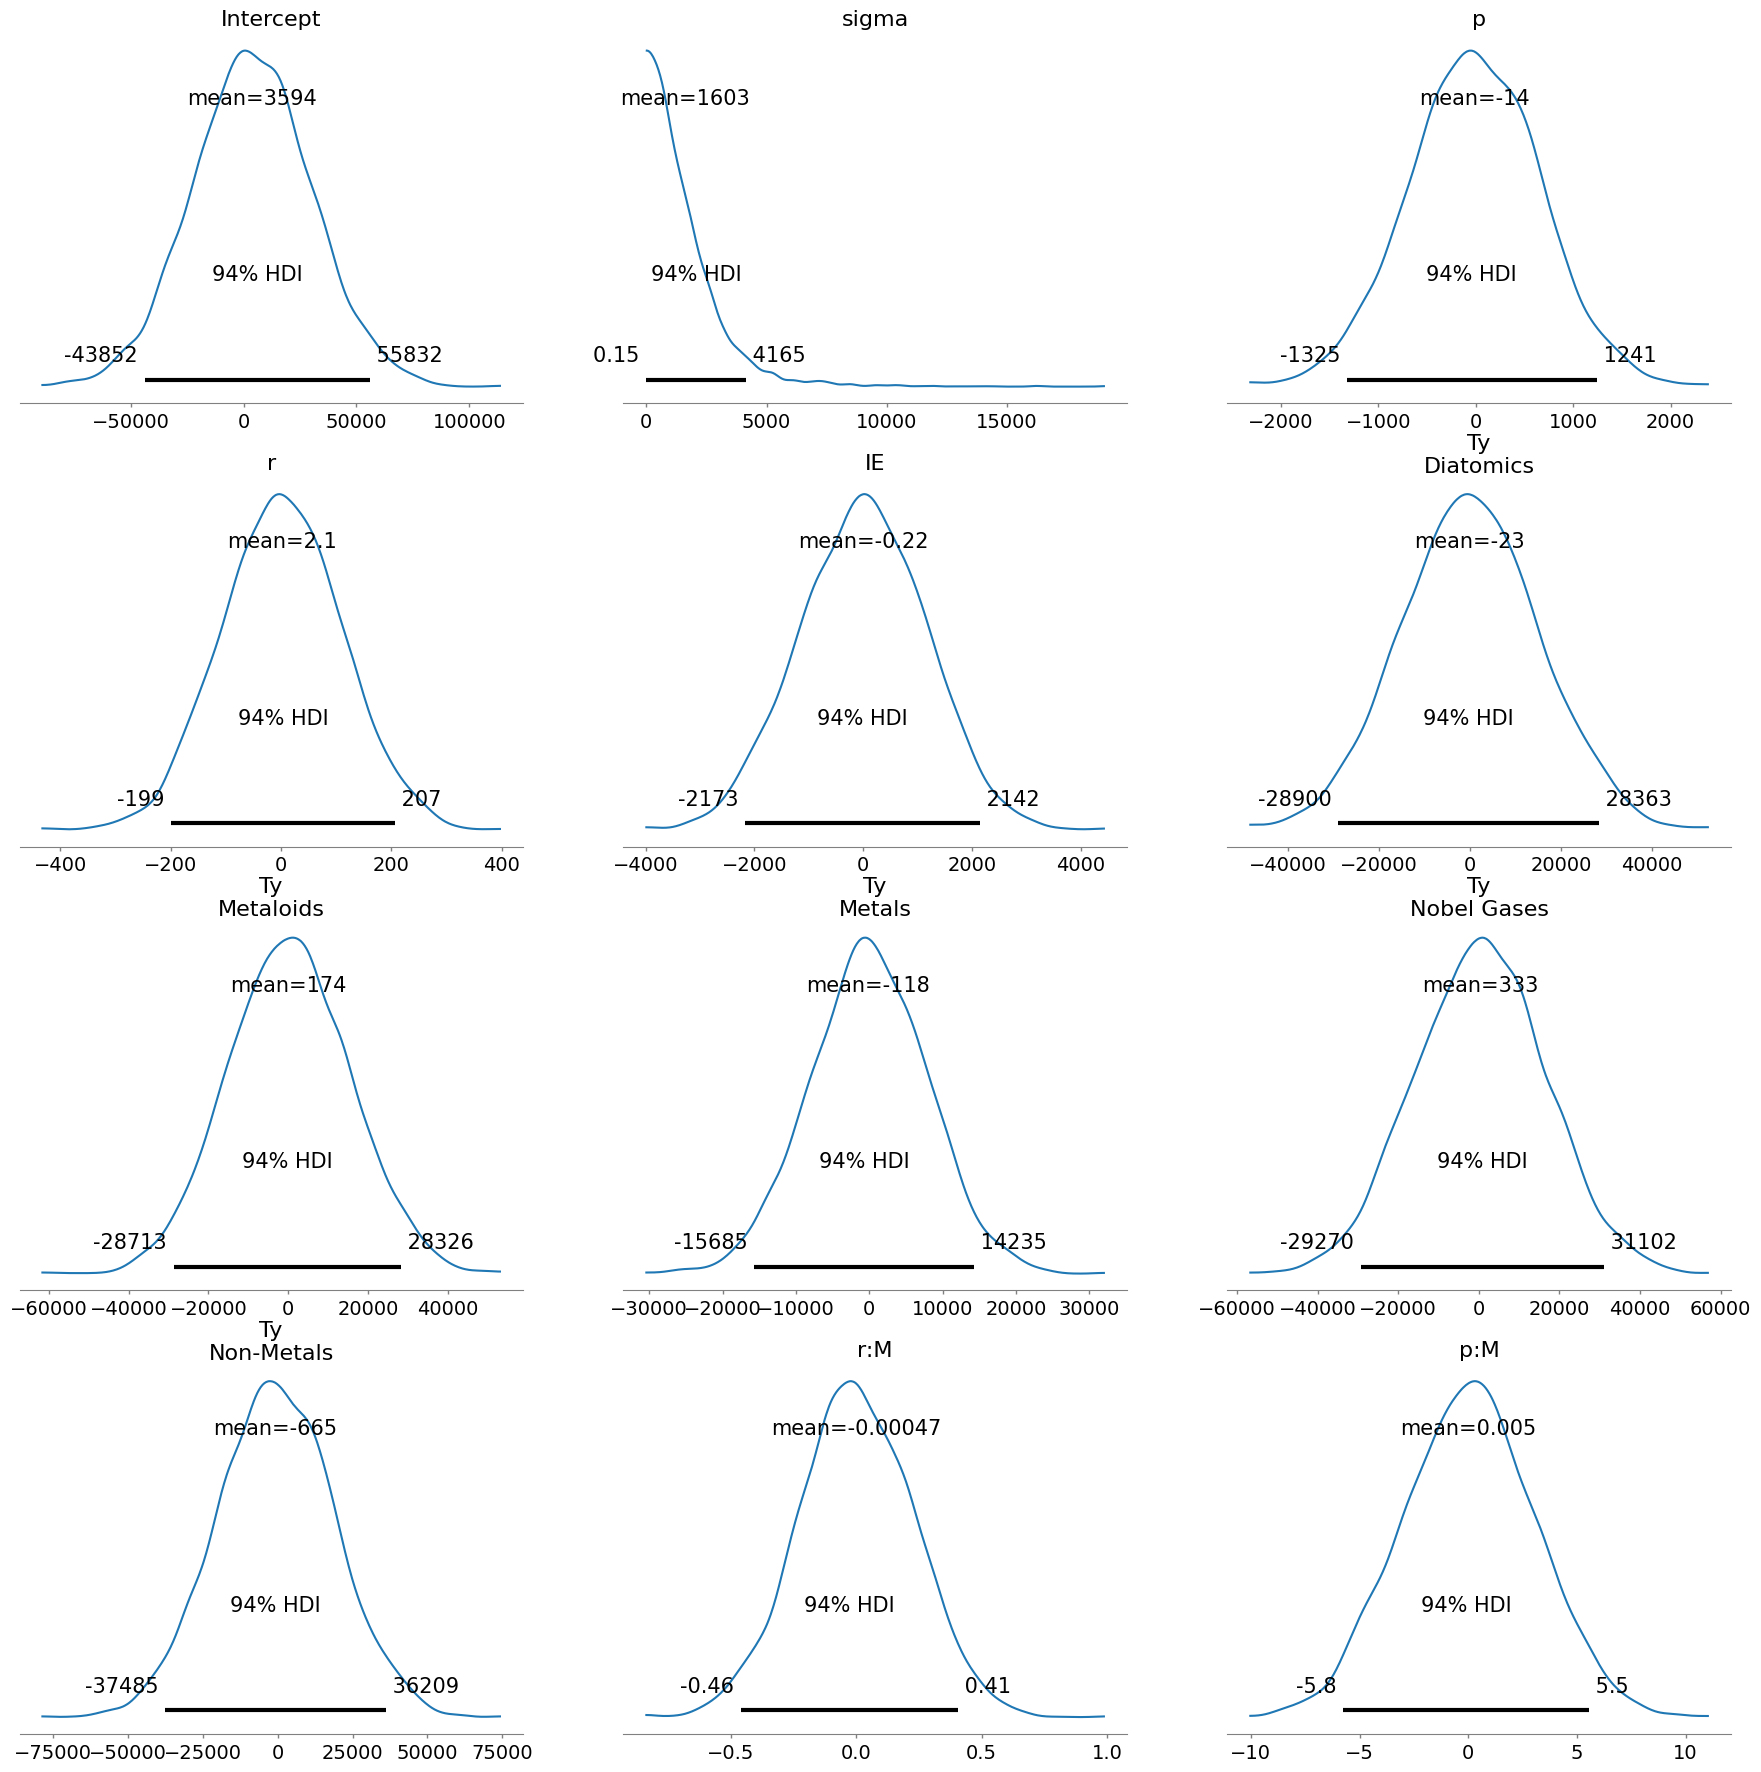

In [ ]:
model_1.plot_priors()

I kinda dont know how to read these graphs, but unlike in my previous models from other units, theres no funny shapes in these priors, so I think thats a good sign. (Last unit they had like 5 different spikes per prior)

array([[<Axes: title={'center': 'IE'}>, <Axes: title={'center': 'IE'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Ty'}>, <Axes: title={'center': 'Ty'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'p:M'}>, <Axes: title={'center': 'p:M'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'r:M'}>, <Axes: title={'center': 'r:M'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

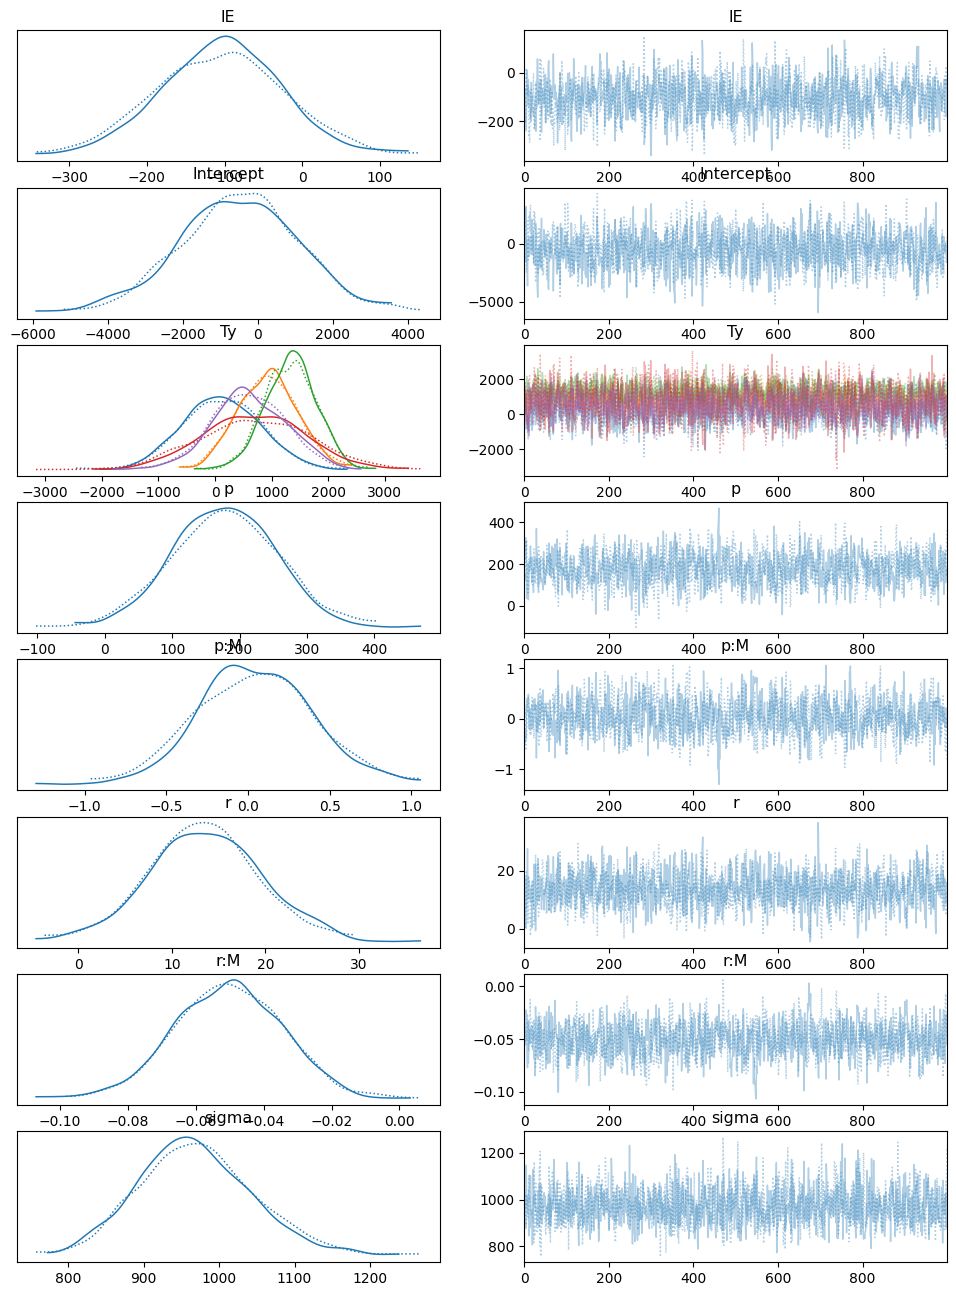

In [ ]:
az.plot_trace(dat_1)

array([[<Axes: title={'center': 'IE'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Ty\nDiatomics'}>],
       [<Axes: title={'center': 'Ty\nMetaloids'}>,
        <Axes: title={'center': 'Ty\nMetals'}>,
        <Axes: title={'center': 'Ty\nNobel Gases'}>],
       [<Axes: title={'center': 'Ty\nNon-Metals'}>,
        <Axes: title={'center': 'p'}>, <Axes: title={'center': 'p:M'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r:M'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

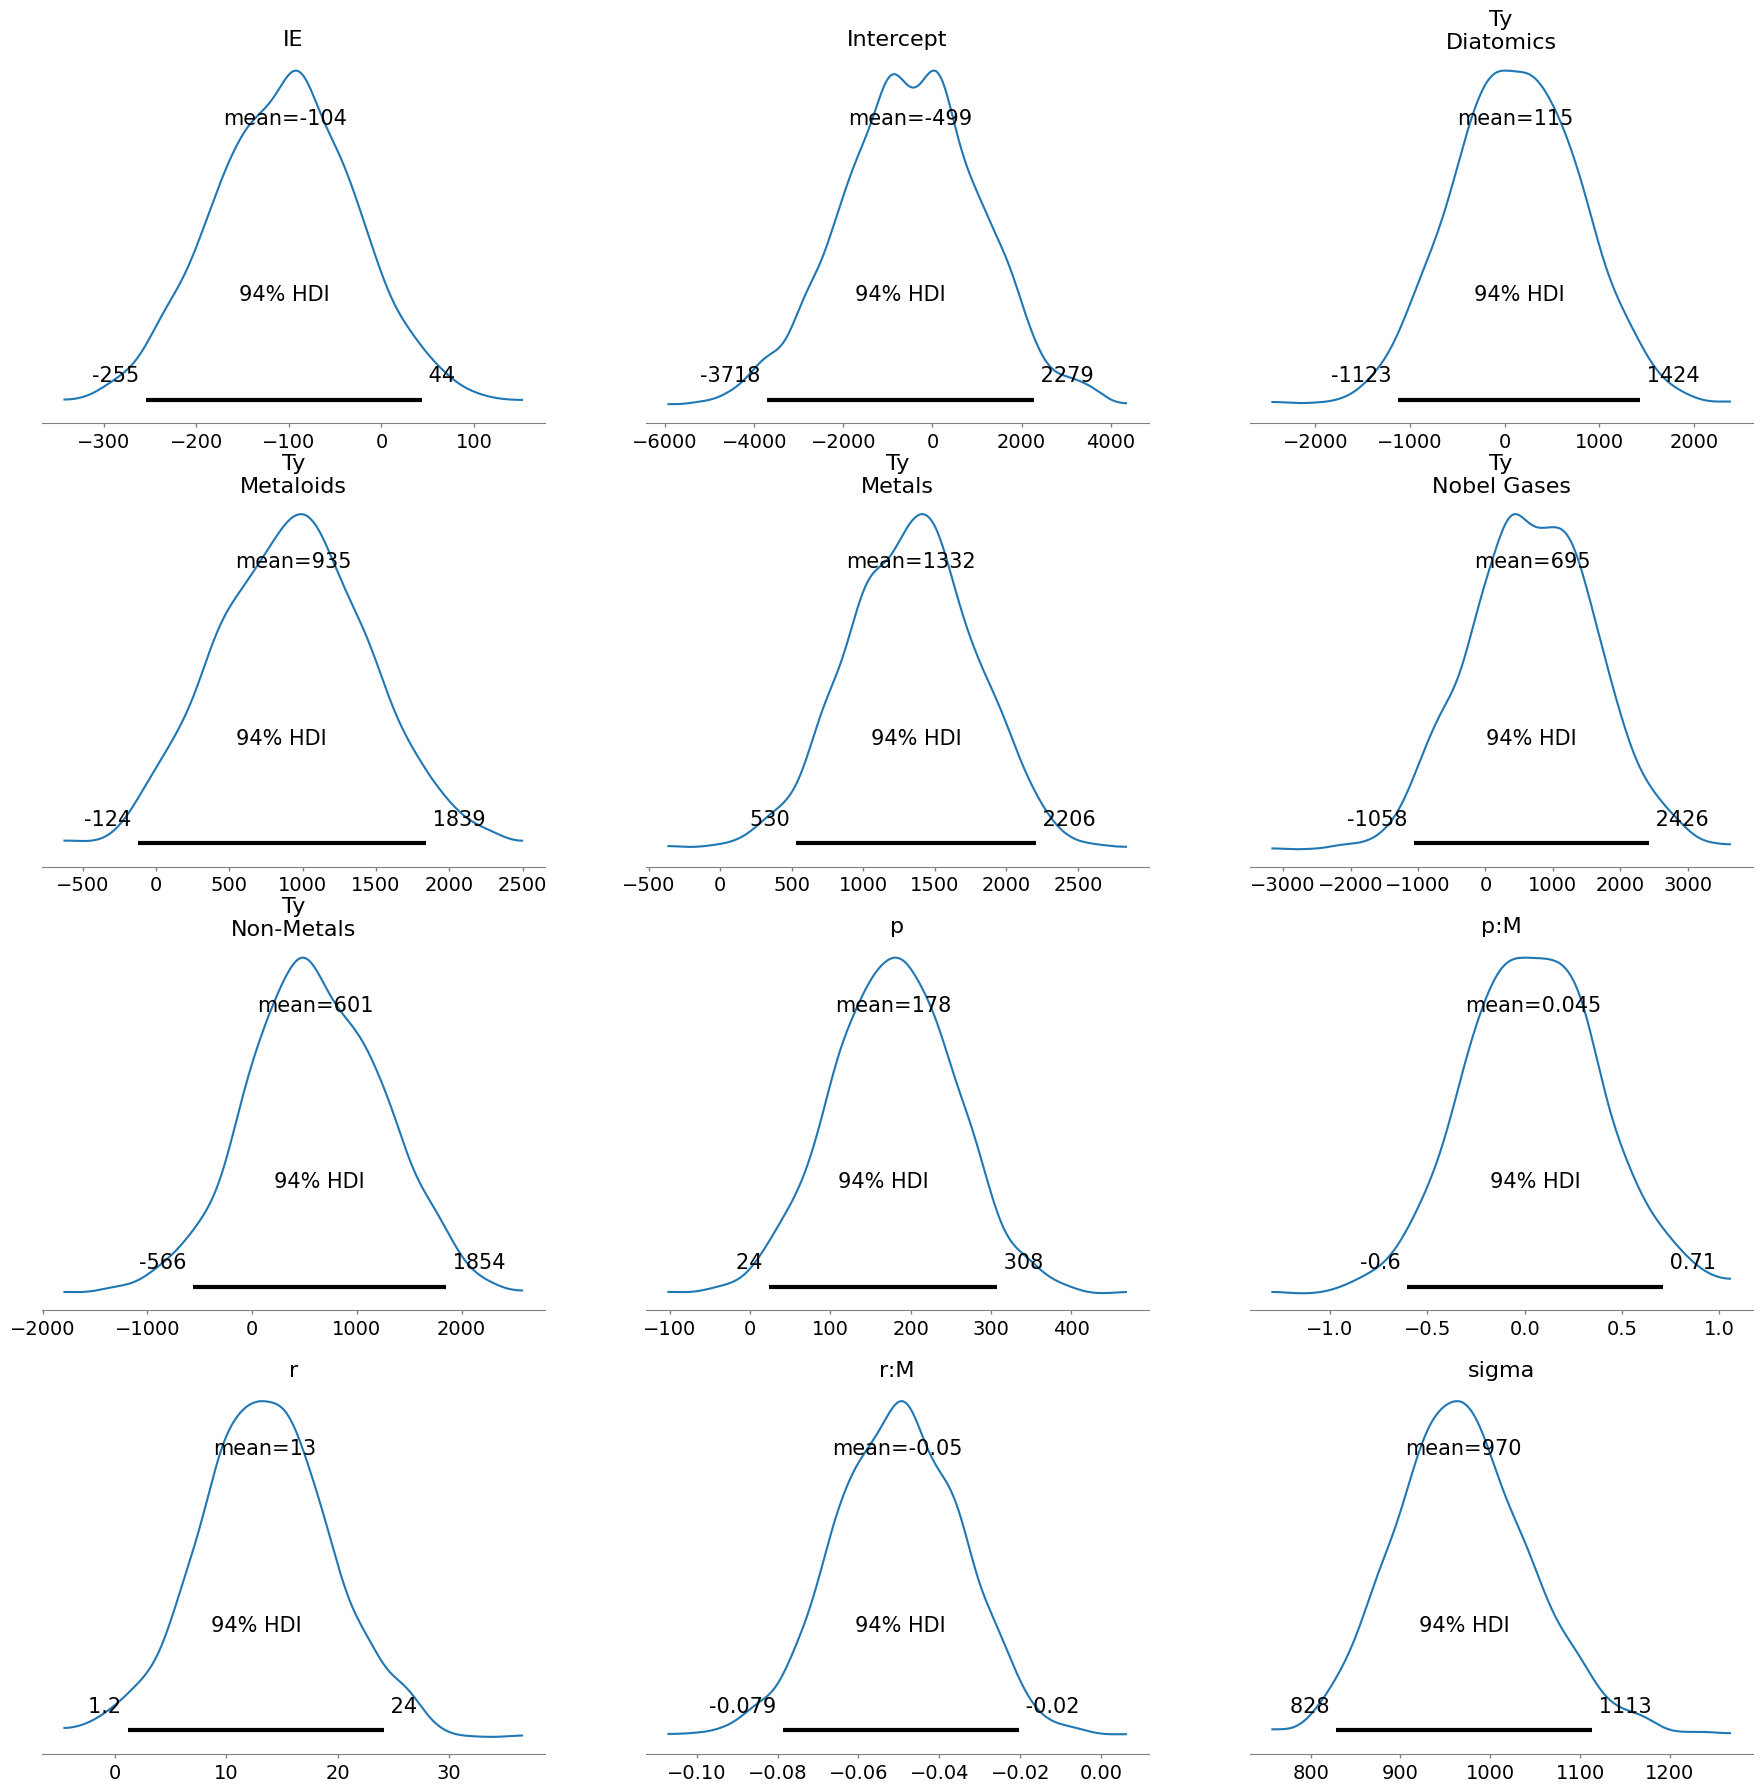

In [ ]:
az.plot_posterior(dat_1)

This was just a bunch of visualization code I ran that ultimately didnt matter

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


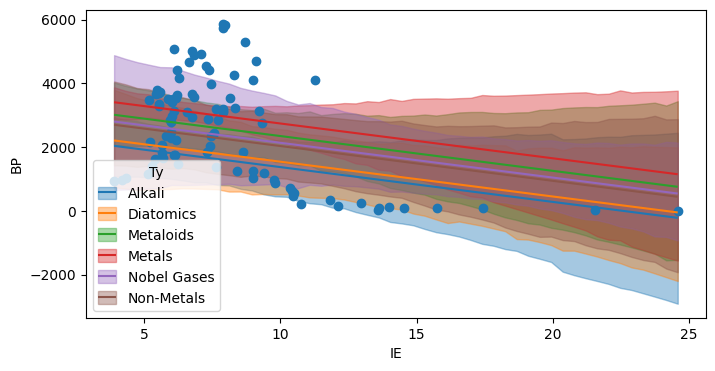

In [ ]:
bmb.interpret.plot_predictions(model_1, dat_1, ["IE", "Ty"], fig_kwargs={"figsize":(8, 4)})
#frame.plot(x="IE", y="BP", figsize=(12, 3), kind="scatter")
plt.scatter(x="IE", y = "BP", data = frame)

<Axes: xlabel='BP'>

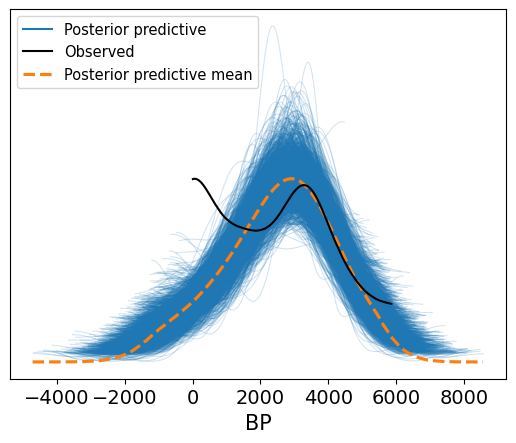

In [ ]:
sam_1 = model_1.predict(dat_1, kind="response")
az.plot_ppc(dat_1)

This looks odd, lets try heirarchies

My choice here is in both `IE` (Ionization energy) and `r` (radius). My rationale is that different element types will interact with these terms differently based on their bonds, such as metalic bonds versus covalent bonds etc.

In [ ]:
model_2 = mod = bmb.Model("BP ~ p + r + IE + Ty + M + r:M +p:M + (IE|Ty) + (r|Ty)", frame)
dat_2 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 216 divergences after tuning. Increase `target_accept` or reparameterize.


200 or so divergences is a pretty bad sign, which is odd since I'm just giving it more parameters

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: title={'center': 'p'}>,
        <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'IE'}>,
        <Axes: title={'center': 'Ty\nDiatomics'}>,
        <Axes: title={'center': 'Ty\nMetaloids'}>,
        <Axes: title={'center': 'Ty\nMetals'}>],
       [<Axes: title={'center': 'Ty\nNobel Gases'}>,
        <Axes: title={'center': 'Ty\nNon-Metals'}>,
        <Axes: title={'center': 'M'}>, <Axes: title={'center': 'r:M'}>],
       [<Axes: title={'center': 'p:M'}>,
        <Axes: title={'center': '1|Ty_sigma'}>,
        <Axes: title={'center': 'IE|Ty_sigma'}>,
        <Axes: title={'center': 'r|Ty_sigma'}>]], dtype=object)

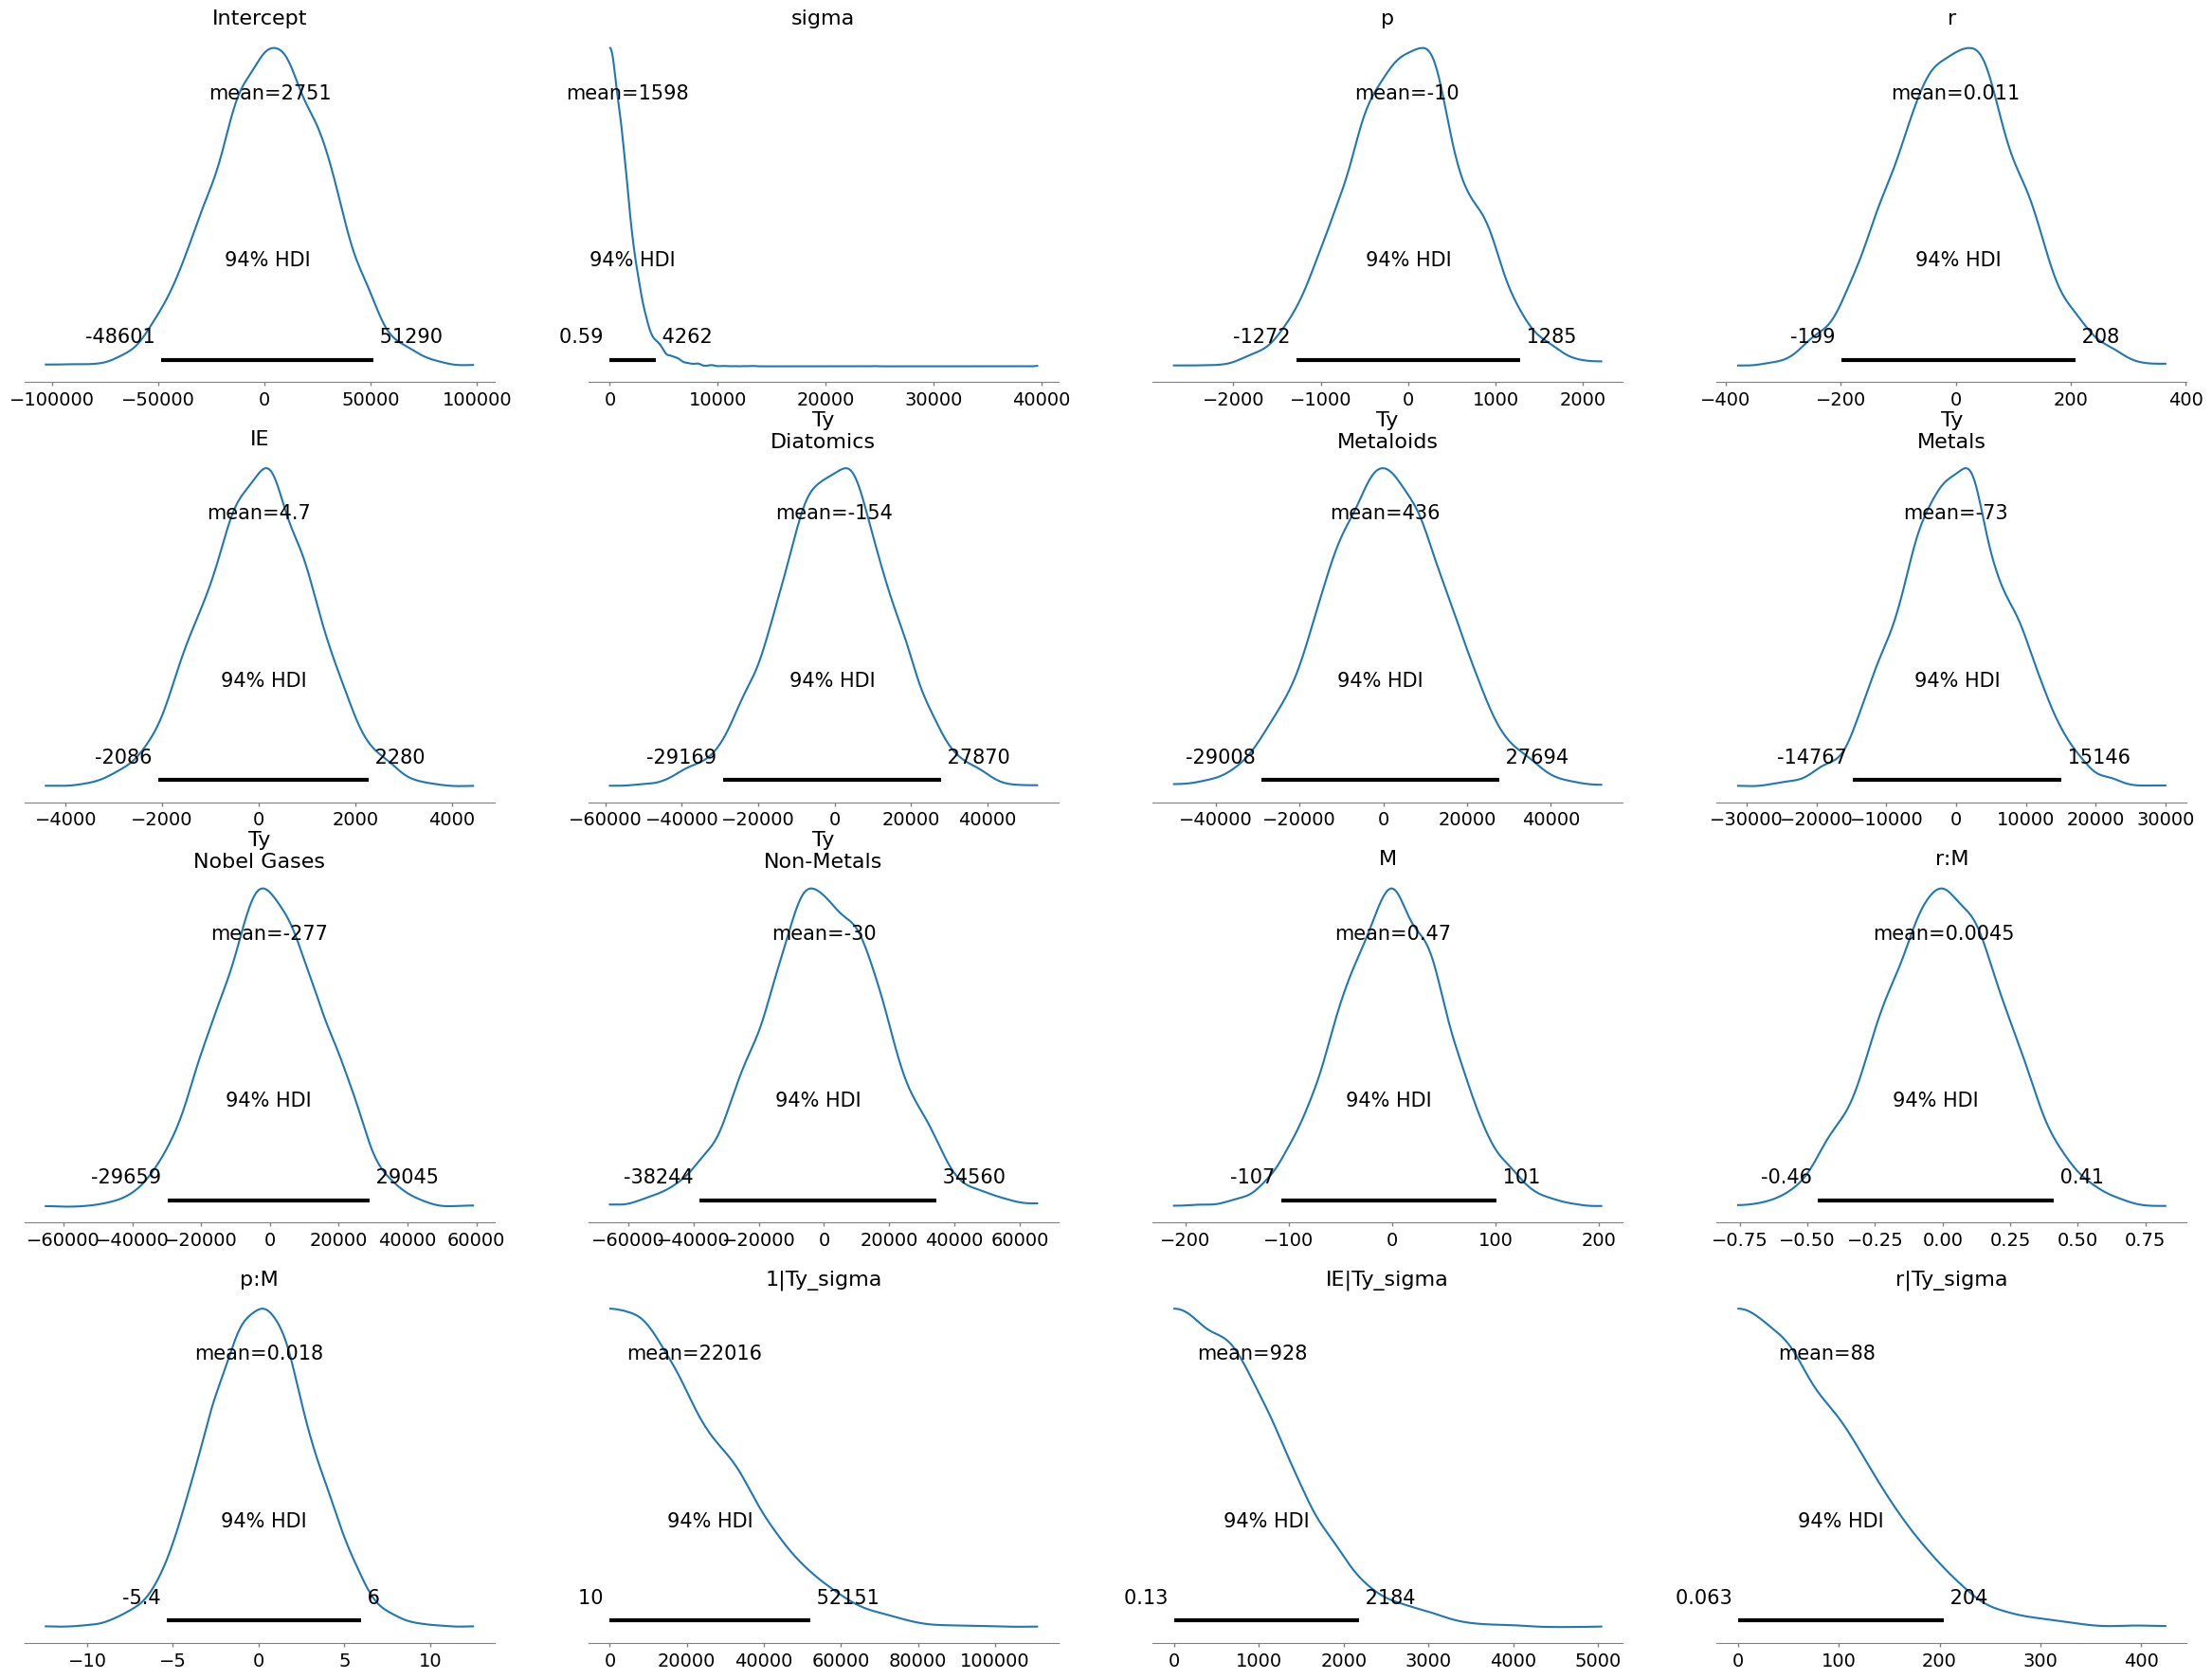

In [ ]:
model_2.plot_priors()

Idk what `1|Ty_sigma` is, but its clearly throwing things offf

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 800x400 with 1 Axes>,
 array([<Axes: xlabel='IE', ylabel='BP'>], dtype=object))

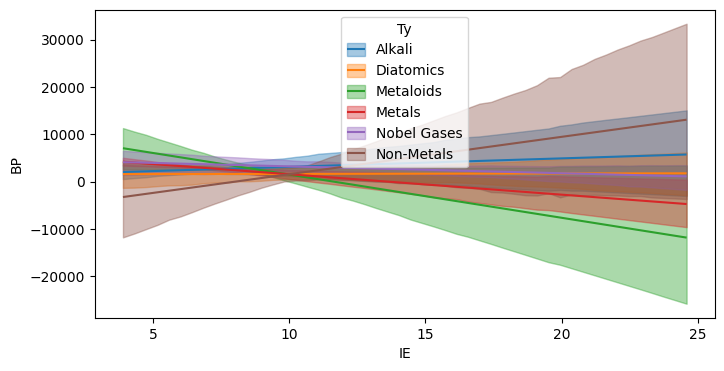

In [ ]:
bmb.interpret.plot_predictions(model_2, dat_2, ["IE", "Ty"], fig_kwargs={"figsize":(8, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


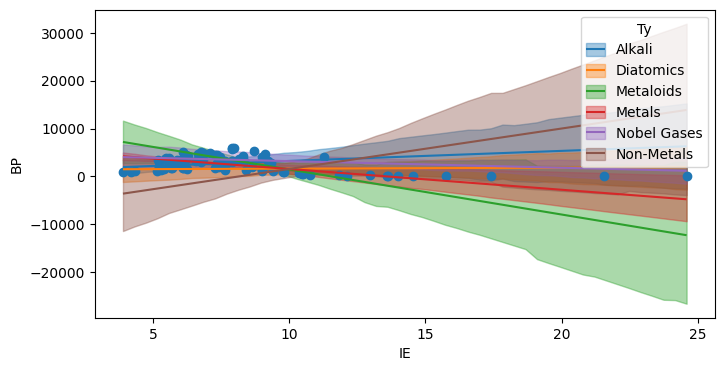

In [ ]:
bmb.interpret.plot_predictions(model_2, dat_2, ["IE", "Ty"], fig_kwargs={"figsize":(8, 4)})
#frame.plot(x="IE", y="BP", figsize=(12, 3), kind="scatter")
plt.scatter(x="IE", y = "BP", data = frame)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


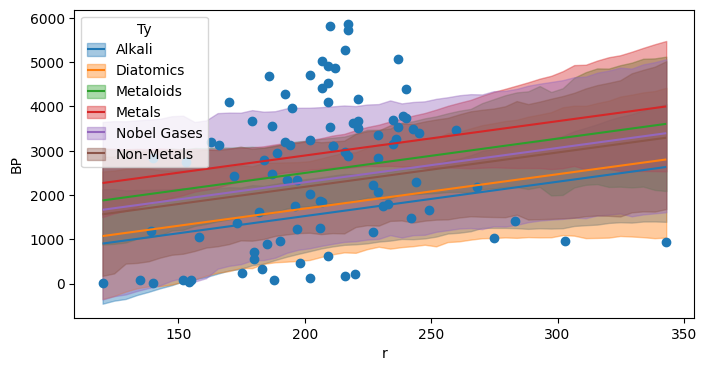

In [ ]:
bmb.interpret.plot_predictions(model_1, dat_1, ["r", "Ty"], fig_kwargs={"figsize":(8, 4)})
#frame.plot(x="IE", y="BP", figsize=(12, 3), kind="scatter")
plt.scatter(x="r", y = "BP", data = frame)

Yeah ok, I cant really read these graphs since theyre so cluttered, and I also couldnt find a way to filter it to just one type (I spent over an hour on this), but it seems like the confidence interval is pretty wide, so I suspect its just making vaguer guesses.

<Axes: xlabel='BP'>

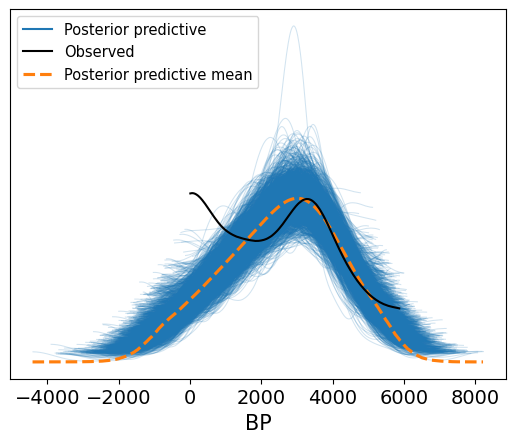

In [ ]:
sam_2 = model_2.predict(dat_2, kind="response")
az.plot_ppc(dat_2)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


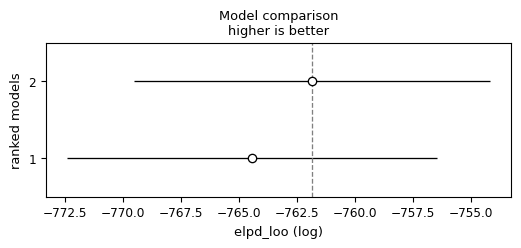

In [ ]:
az.plot_compare(az.compare({'1':dat_1, '2':dat_2}));

Despite the divergences, our second model did better, this makes sense to me, the kind of atom will influence what the impact of radius and IE will be on how well the atom can form intermolecular forces.

Metals and Alkali can form a sea of electrons which I suspect would act like resonance and improve stability, so a larger radius means more shared area, while for nonmetals, metaloids, and diatomics which have more constrained electrons this would break even, which we observe.

Wierdly however, nobel gases increase in BP as radius increases, I wonder why

Also noteworthy is how the interaction terms are almost 0, mass has very little effect on its deriviative terms, so I'll drop it from here on out

(Foreshadowing alert, this was a terrible idea)

In [ ]:
model_2r = mod = bmb.Model("BP ~ p + r + IE + Ty + M + (IE|Ty) + (r|Ty)", frame)
dat_2r = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 199 divergences after tuning. Increase `target_accept` or reparameterize.


Now lets try changing out the heirarchies for interactions

In [ ]:
model_3 = mod = bmb.Model("BP ~ p + r + IE + Ty + M + (IE:Ty) + (r:Ty)", frame)
dat_3 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

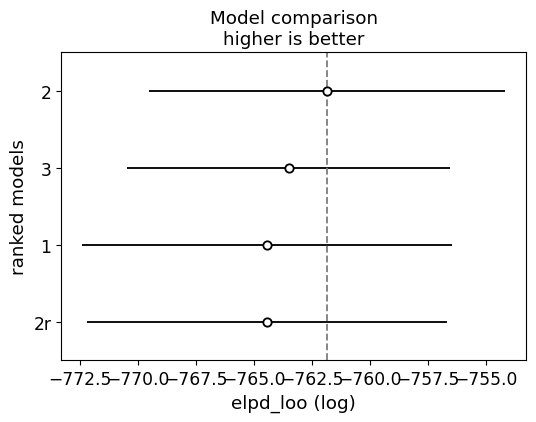

In [ ]:
az.plot_compare(az.compare({'1':dat_1, '2':dat_2, '2r': dat_2r, '3': dat_3}));

Wierd that our models based on removing the wierd interaction terms did worse, they had such small coeficients, but clearly their contributing. I'm probably forgeting the scale of my data. I'll confirm this by making a reduced model 1 and seeing if it does much worse

We'll make our `1r` model just be model 1 minus the interaction with mass terms since those did poorly, and also add back mass cuz I was a dumb dumb and forgot it first time.

In [ ]:
model_1r = mod = bmb.Model("BP ~ p + r + IE + Ty + M", frame)
dat_1r = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

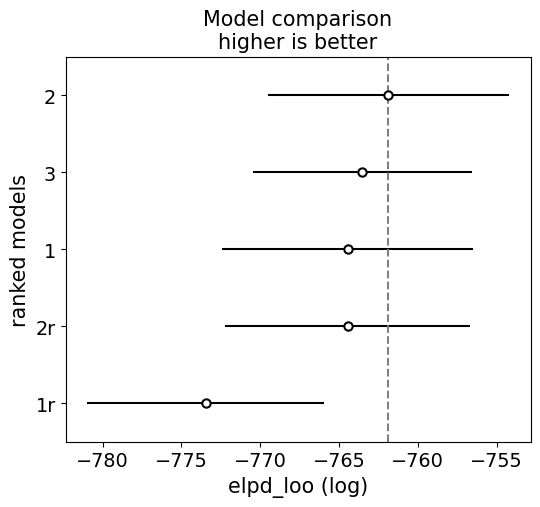

In [ ]:
az.plot_compare(az.compare({'1':dat_1, '2':dat_2, '2r': dat_2r, '3': dat_3, '1r': dat_1r}));

Hypothesis supported, those terms seem to contribute alot (and my gut instinct was right?)

Now lets add those terms back to my `model_3`, to make `3e`, I suspect this one with its greater items will do better than `2`

In [ ]:
model_3e = mod = bmb.Model("BP ~ p + r + IE + Ty + M + (IE:Ty) + (r:Ty) + M + r:M +p:M", frame)
dat_3e = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

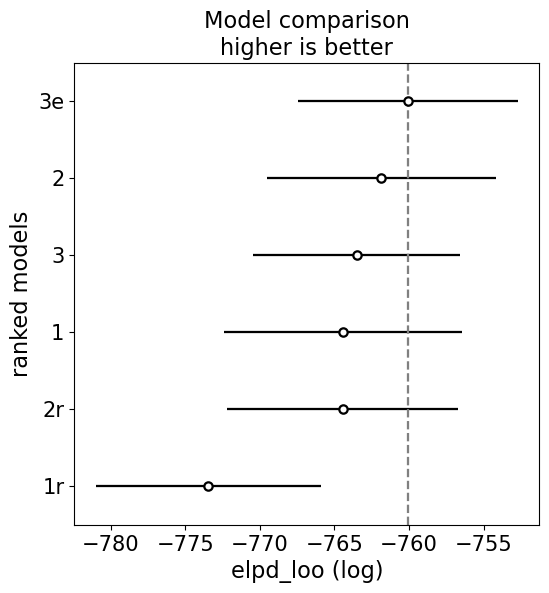

In [ ]:
az.plot_compare(az.compare({'1':dat_1, '2':dat_2, '2r': dat_2r, '3': dat_3, '1r': dat_1r, '3e': dat_3e}));

And it did, by a fair bit too, seems like indeed replacing heirarchies with interactions and keeping the mass interactions helps.

I'd like to note here, that it is strange to me at least that an interaction between a categorical does better than a heirarchy, but I would have to guess its because it acts like an influence modifier on that predictor by type.

I'll finally add in density `p`, with both interaction and heirarchical terms. I know density is a good predictor, and given how the last models did, I suspect the interaction model `4i` will do better, (with `4c` in close competition)

In [ ]:
model_4i = mod = bmb.Model("BP ~ p + r + IE + Ty + M + (p:Ty) + (IE:Ty) + (r:Ty) + M + r:M +p:M", frame)
dat_4i = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_4c = mod = bmb.Model("BP ~ p + r + IE + Ty + M + (p|Ty) + (IE:Ty) + (r:Ty) + M + r:M +p:M", frame)
dat_4c = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 184 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

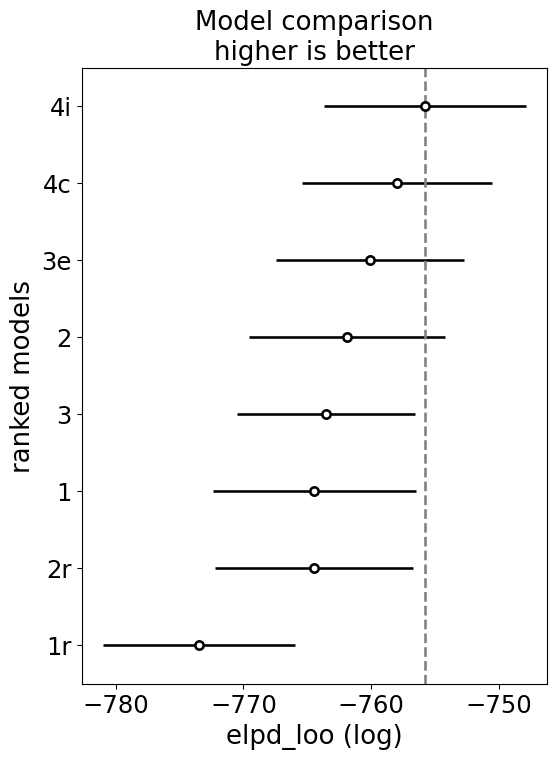

In [ ]:
az.plot_compare(az.compare({'1':dat_1, '2':dat_2, '2r': dat_2r, '3': dat_3, '1r': dat_1r, '3e': dat_3e, '4i': dat_4i, '4c': dat_4c}));

<Axes: xlabel='BP'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


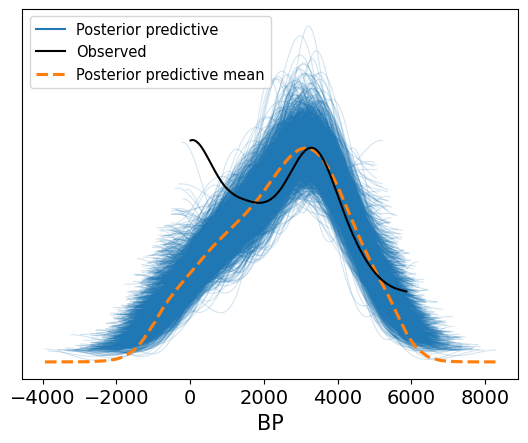

In [ ]:
sam_4i = model_4i.predict(dat_4i, kind="response")
az.plot_ppc(dat_4i)

Comparatively, its not all that much better, clearly there is something making my distribution bimodal that I wasnt able to encompass. I wonder if this relates to that split in the metals I mentioned way back, or if perhaps the model is failing at predicting certain types of elements.

I was right, now lets see how this best model does at various tasks

## Visualizing `model_4i`

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 800x400 with 1 Axes>,
 array([<Axes: xlabel='p', ylabel='BP'>], dtype=object))

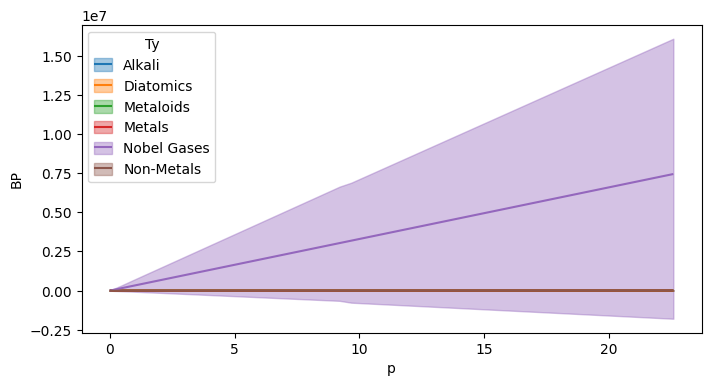

In [ ]:
bmb.interpret.plot_predictions(model_4i, dat_4i, ["p", "Ty"], fig_kwargs={"figsize":(8, 4)})

That looks weird, it seems like it has 0 confidence in the boiling points of Nobel Gases, and I could not say why. I can also say its wierd to say its possible for it to be negative when its a Kelvin Scale.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 800x400 with 1 Axes>,
 array([<Axes: xlabel='p', ylabel='BP'>], dtype=object))

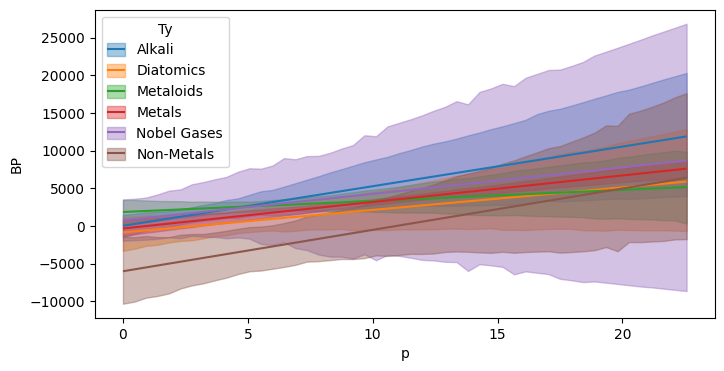

In [ ]:
bmb.interpret.plot_predictions(model_4c, dat_4c, ["p", "Ty"], fig_kwargs={"figsize":(8, 4)})

## Random Models

### Declarations

In [ ]:
params = ['r', 'M', 'p', 'Ty', 'IE']

In [ ]:
def Stringify(mods):
  o = []
  u = set()
  for mod in mods:
    #print(mod[1])
    if mod[0] == 'intr':
      u.add(mod[1])
      u.add(mod[2])
      o.append(f'{mod[1]}:{mod[2]}')
    elif mod[0] == 'heir':
      u.add(mod[1])
      u.add("Ty")
      o.append(f'({mod[1]}|Ty)')
    elif mod[0] == 'raw':
      u.add(mod[1])
  s = 'BP ~ '+' + '.join([str(x) for x in u])+' + '+' + '.join(o)
  return s.replace(' +  + ', ' + ').rstrip(' + ')

In [ ]:
Stringify([('raw', 'Ty')])

'BP ~ Ty'

In [ ]:
def RandAmt(p):
  n=0
  while np.random.rand() < p:
    n += 1
  return n

In [ ]:
def GenRandModel():
  o = set()
  for i in range(RandAmt(.6)):
    opt1 = np.random.choice(params)
    opt2 = np.random.choice(params)
    if opt1 == opt2:
      continue
    opts = sorted([opt1, opt2])
    o.add(('intr', opts[0], opts[1]))
  for i in range(RandAmt(.5)):
    opt1 = np.random.choice(params)
    if opt1 == 'Ty':
      continue
    o.add(('heir', opt1))
  for i in range(RandAmt(.4)):
    opt1 = np.random.choice(params)
    o.add(('raw', opt1))
  o = sorted(list(o))
  return tuple(o)

In [ ]:
Stringify(GenRandModel())

'BP ~ Ty + IE + M + (M|Ty) + IE:Ty'

In [ ]:
best_loo = -756.0365845364524 #Loo value for model_4i

In [ ]:
models = {}

### Computing Models

In [ ]:
for i in range(2):
  modn = GenRandModel()
  if modn not in models:
    sm = Stringify(modn)
    if sm == 'BP ~':
      continue
    print(f'Training model `{sm}`')
    model = bmb.Model(sm, frame)
    data = model.fit(idata_kwargs={'log_likelihood': True})
    perf = az.loo(data).elpd_loo
    models[modn] = (data, perf)
    rel_loo = (perf-best_loo)
    print(f'\n!!!!\tPerformed with: {perf}, = {"%+f"%rel_loo} relative to Model_4i')
    comps = {Stringify(modn):data for modn, (data, perf) in models.items()}
    if len(comps.items()) > 1:
      az.plot_compare(az.compare(comps));

Training model `BP ~ Ty + IE + IE:Ty`


Output()

Output()

ERROR:pymc.stats.convergence:There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -758.0125687679653, = -1.975984 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Sampling chain 1, 65 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:02:59

ERROR:pymc.stats.convergence:There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obs


!!!!	Performed with: -756.887517772212, = -0.850933 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

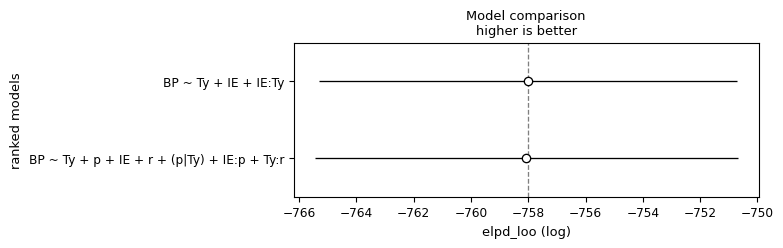

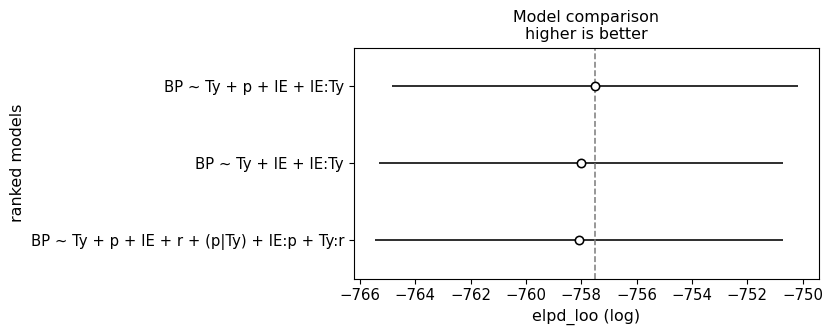

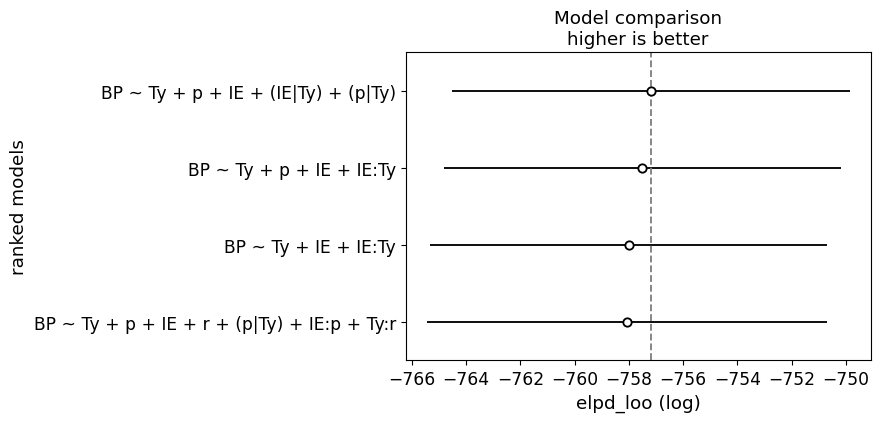

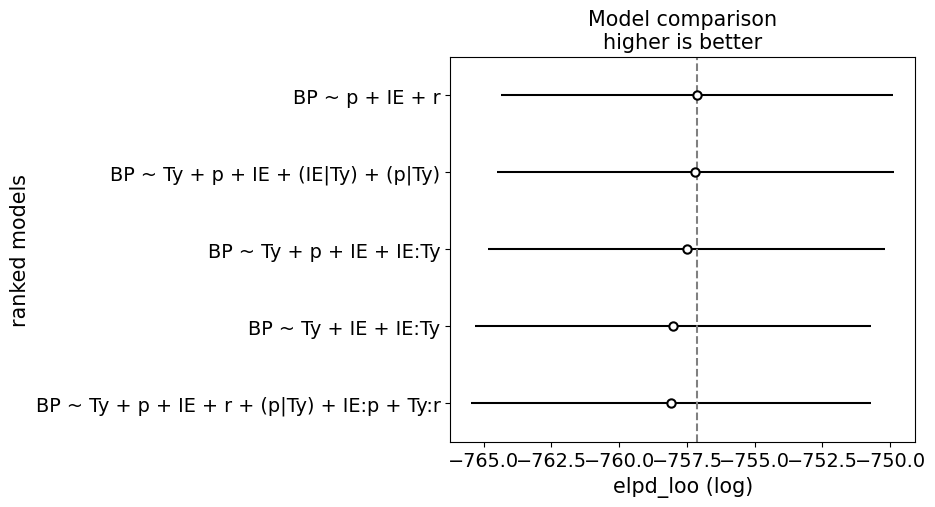

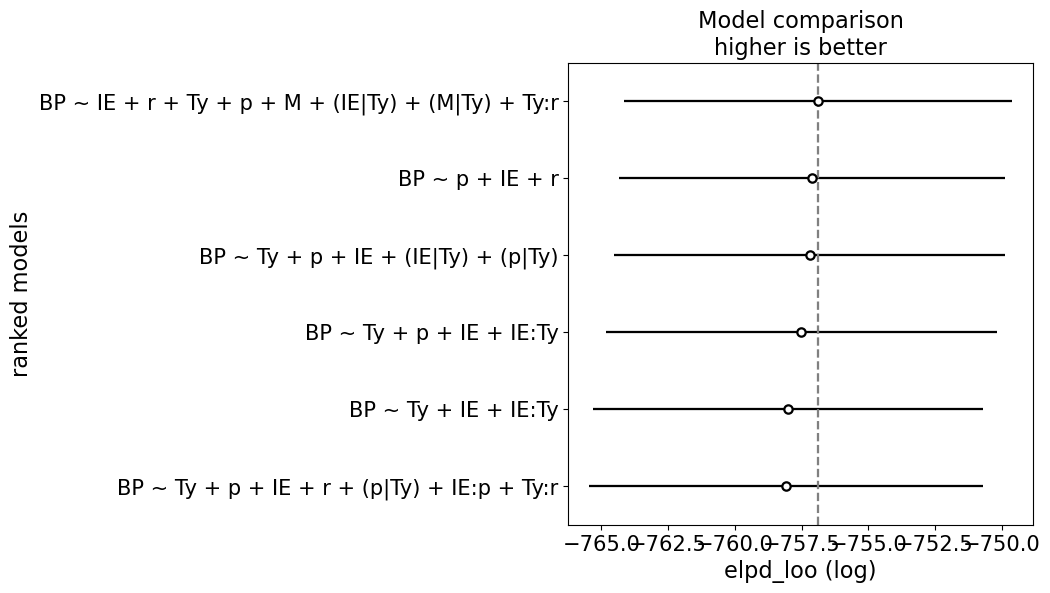

In [ ]:
for i in range(5):
  modn = GenRandModel()
  if modn not in models:
    sm = Stringify(modn)
    if sm == 'BP ~':
      continue
    print(f'Training model `{sm}`')
    model = bmb.Model(sm, frame)
    data = model.fit(idata_kwargs={'log_likelihood': True})
    perf = az.loo(data).elpd_loo
    models[modn] = (data, perf)
    rel_loo = (perf-best_loo)
    print(f'\n!!!!\tPerformed with: {perf}, = {"%+f"%rel_loo} relative to Model_4i')
    comps = {Stringify(modn):data for modn, (data, perf) in models.items()}
    if len(comps.items()) > 1:
      az.plot_compare(az.compare(comps));

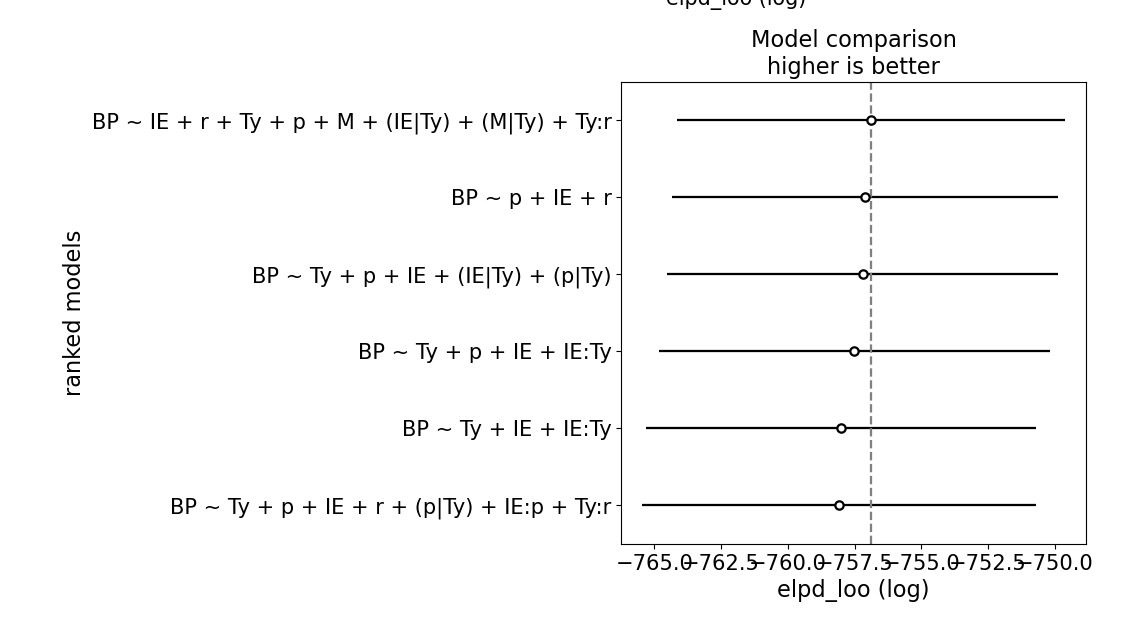

In [ ]:
perf.elpd_loo

-757.3814304006032

In [ ]:
for i in range(100):
  modn = GenRandModel()
  if modn not in models:
    sm = Stringify(modn)
    if sm == 'BP ~':
      continue
    print(f'Training model `{sm}`')
    model = bmb.Model(sm, frame)
    data = model.fit(idata_kwargs={'log_likelihood': True})
    perf = az.loo(data).elpd_loo
    models[modn] = (data, perf)
    rel_loo = (perf-best_loo)
    print(f'\n!!!!\tPerformed with: {perf}, = {"%+f"%rel_loo} relative to Model_4i')
    comps = {Stringify(modn):data for modn, (data, perf) in models.items()}
    pcomps = {Stringify(modn):az.loo(data).elpd_loo for modn, (data, perf) in models.items()}
    print(repr(pcomps))
if len(comps.items()) > 1:
  az.plot_compare(az.compare(comps));

Training model `BP ~ r`


Output()

Output()


!!!!	Performed with: -817.9279434949984, = -61.891359 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984}
Training model `BP ~ Ty + p + IE + (IE|Ty) + IE:p`


Output()

Output()

ERROR:pymc.stats.convergence:There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -780.668744606657, = -24.632160 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657}
Training model `BP ~ Ty + IE + (IE|Ty)`


Output()

Output()

ERROR:pymc.stats.convergence:There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -787.7252015291399, = -31.688617 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399}
Training model `BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p`


Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -768.0752355470916, = -12.038651 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916}
Training model `BP ~ Ty + p + IE + r + Ty:r`


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -782.9724001880259, = -26.935816 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259}
Training model `BP ~ Ty + p + M + IE + IE:M + Ty:p`


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -769.1876579021282, = -13.151073 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282}
Training model `BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r`


Output()

Output()

ERROR:pymc.stats.convergence:There were 955 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -773.8438575069189, = -17.807273 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189}
Training model `BP ~ Ty + r + Ty:r`


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -786.3161737507709, = -30.279589 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709}
Training model `BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p`


Output()

Output()

ERROR:pymc.stats.convergence:There were 242 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -783.8936113984817, = -27.857027 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817}
Training model `BP ~ r + p + M + IE + IE:r + p:r`


Output()

Output()


!!!!	Performed with: -773.8408407987655, = -17.804256 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655}
Training model `BP ~ r + p + p:r`


Output()

Output()


!!!!	Performed with: -791.2608470497821, = -35.224263 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821}
Training model `BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:

Output()

Output()

ERROR:pymc.stats.convergence:There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -759.358168619067, = -3.321584 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -779.3834792529492, = -23.346895 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -786.2893450752189, = -30.252761 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -783.5761277450852, = -27.539543 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -774.338477335903, = -18.301893 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -791.2087765791592, = -35.172192 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -778.8701294373224, = -22.833545 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -763.7271324069759, = -7.690548 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.7252015291399, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 477 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -787.4180569246955, = -31.381472 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 940 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -771.6639295754794, = -15.627345 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -787.0937340906925, = -31.057150 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -779.2742556829824, = -23.237671 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -779.2822789605397, = -23.245694 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -790.3181987493283, = -34.281614 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -767.521144293524, = -11.484560 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -813.2662895451191, = -57.229705 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -778.6716873109465, = -22.635103 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -806.9188805049988, = -50.882296 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -778.4025824353939, = -22.365998 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -770.758759878247, = -14.722175 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -761.4562299399422, = -5.419645 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -766.1557306198445, = -10.119146 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -786.5816534171246, = -30.545069 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -782.7133159603434, = -26.676731 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -773.0350847412263, = -16.998500 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -778.8377603149821, = -22.801176 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -768.0004998751532, = -11.963915 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -790.0335702840886, = -33.996986 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 381 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -770.7274893759695, = -14.690905 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -774.6250863166439, = -18.588502 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -787.0738790750514, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -786.6335677408537, = -30.596983 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -773.9880857441896, = -17.951501 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -784.5678556974243, = -28.531271 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



!!!!	Performed with: -786.2745473798485, = -30.237963 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 131 divergences after tuning. Increase `target_accept` or reparameterize.



!!!!	Performed with: -788.6540269132756, = -32.617442 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -803.6463340223216, = -47.609749 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -772.7012418572206, = -16.664657 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -778.6284417737091, = -22.591857 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -763.7516110363357, = -7.715026 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -777.216093584575, = -21.179509 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -775.1390687361093, = -19.102484 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -770.3771998906432, = -14.340615 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -769.9559209528684, = -13.919336 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -786.3613750802365, = -30.324791 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -788.4391027557034, = -32.402518 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -758.0085270026519, = -1.971942 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -790.3188564539897, = -34.282272 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -762.1574460142184, = -6.120861 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -788.7339584074917, = -32.697374 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -775.3318269837172, = -19.295242 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -790.4961683159733, = -34.459584 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -773.3713601668535, = -17.334776 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.6335677408537, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 142 divergences after tuning. Increase `target_accept` or reparameterize.



!!!!	Performed with: -786.8258133493756, = -30.789229 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -764.9959163341682, = -8.959332 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -783.0970651580413, = -27.060481 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 459 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -788.0614772247609, = -32.024893 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -770.8850435429019, = -14.848459 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -787.9451495001994, = -31.908565 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()


!!!!	Performed with: -783.1245701136473, = -27.087986 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -761.9765208848305, = -5.939936 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

Output()

Output()

ERROR:pymc.stats.convergence:There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



!!!!	Performed with: -787.2041365613405, = -31.167552 relative to Model_4i


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

{'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

In [ ]:
print(models.keys())

dict_keys([(('heir', 'r'), ('raw', 'Ty')), (('heir', 'p'), ('intr', 'M', 'p')), (('heir', 'p'), ('intr', 'M', 'Ty'), ('intr', 'p', 'r')), (('raw', 'IE'),), (('heir', 'M'), ('intr', 'M', 'Ty'), ('intr', 'M', 'r')), (('intr', 'IE', 'M'), ('intr', 'IE', 'r'), ('intr', 'M', 'p'), ('raw', 'Ty')), (('raw', 'r'),), (('heir', 'IE'), ('intr', 'IE', 'p')), (('heir', 'IE'), ('raw', 'Ty')), (('intr', 'IE', 'M'), ('intr', 'IE', 'r'), ('intr', 'M', 'p'), ('intr', 'Ty', 'p')), (('intr', 'Ty', 'r'), ('raw', 'IE'), ('raw', 'p'), ('raw', 'r')), (('intr', 'IE', 'M'), ('intr', 'Ty', 'p')), (('heir', 'p'), ('intr', 'IE', 'r'), ('raw', 'M'), ('raw', 'Ty')), (('intr', 'Ty', 'r'),), (('heir', 'p'), ('intr', 'IE', 'r'), ('intr', 'Ty', 'p'), ('raw', 'Ty')), (('intr', 'IE', 'r'), ('intr', 'p', 'r'), ('raw', 'M')), (('intr', 'p', 'r'),), (('heir', 'p'), ('heir', 'r'), ('intr', 'IE', 'Ty'), ('intr', 'IE', 'p'), ('intr', 'IE', 'r'), ('intr', 'M', 'Ty'), ('intr', 'M', 'r')), (('heir', 'p'), ('heir', 'r')), (('intr',

### Anaylysis

Below is a screenshot of my initial run in case it gets corrupted, and Ive also embeded a dictionary of the model strings and their loo performance.

image.png

In [ ]:
pcomps = {'BP ~ Ty + r + (r|Ty)': -786.8258133493756, 'BP ~ Ty + M + p + (p|Ty) + M:p': -777.5267940398363, 'BP ~ Ty + r + M + p + (p|Ty) + M:Ty + p:r': -766.0183510064822, 'BP ~ IE': -806.5258363099891, 'BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r': -789.578679599384, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p': -772.3736416986433, 'BP ~ r': -817.9279434949984, 'BP ~ Ty + p + IE + (IE|Ty) + IE:p': -780.668744606657, 'BP ~ Ty + IE + (IE|Ty)': -787.4180569246955, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:p + Ty:p': -768.0752355470916, 'BP ~ Ty + p + IE + r + Ty:r': -782.9724001880259, 'BP ~ Ty + p + M + IE + IE:M + Ty:p': -769.1876579021282, 'BP ~ r + Ty + IE + M + p + (p|Ty) + IE:r': -773.8438575069189, 'BP ~ Ty + r + Ty:r': -786.3161737507709, 'BP ~ Ty + r + IE + p + (p|Ty) + IE:r + Ty:p': -783.8936113984817, 'BP ~ r + p + M + IE + IE:r + p:r': -773.8408407987655, 'BP ~ r + p + p:r': -791.2608470497821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r': -759.358168619067, 'BP ~ Ty + r + p + (p|Ty) + (r|Ty)': -779.3834792529492, 'BP ~ Ty + r + M + IE + IE:Ty': -786.2893450752189, 'BP ~ p + IE + IE:p': -783.5761277450852, 'BP ~ r + p + IE + M + M:p + M:r': -774.338477335903, 'BP ~ Ty + r + M + IE + IE:r + M:Ty': -791.2087765791592, 'BP ~ Ty + IE + p + (p|Ty)': -778.8701294373224, 'BP ~ IE + Ty + r + M + p + (r|Ty) + IE:M + Ty:p': -763.7271324069759, 'BP ~ Ty + r + M + p + (p|Ty) + M:r': -771.6639295754794, 'BP ~ Ty + r + M + IE + IE:Ty + M:r': -787.0937340906925, 'BP ~ Ty + r + p + (p|Ty)': -779.2822789605397, 'BP ~ p': -790.3181987493283, 'BP ~ r + Ty + IE + M + p + IE:M + IE:p + M:Ty + M:p + Ty:r': -767.521144293524, 'BP ~ M': -813.2662895451191, 'BP ~ Ty + p + (p|Ty)': -778.6716873109465, 'BP ~ r + IE + IE:r': -806.9188805049988, 'BP ~ Ty + r + IE + p + (p|Ty) + Ty:r': -778.4025824353939, 'BP ~ p + M + IE + IE:p': -770.758759878247, 'BP ~ r + Ty + IE + M + p + (IE|Ty) + (M|Ty) + (p|Ty) + M:r': -761.4562299399422, 'BP ~ r + Ty + IE + M + p + IE:M + IE:Ty + IE:p + Ty:r + p:r': -766.1557306198445, 'BP ~ Ty': -786.5816534171246, 'BP ~ Ty + p + IE': -782.7133159603434, 'BP ~ Ty + IE + p + (p|Ty) + IE:Ty': -773.0350847412263, 'BP ~ Ty + r + p + Ty:p + Ty:r': -778.8377603149821, 'BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:M + M:r + Ty:r + p:r': -768.0004998751532, 'BP ~ Ty + r + M + M:Ty + M:r': -790.0335702840886, 'BP ~ Ty + IE + M + p + (p|Ty) + IE:M + IE:p': -770.7274893759695, 'BP ~ Ty + r + IE + p + (p|Ty) + (r|Ty) + IE:Ty': -774.6250863166439, 'BP ~ r + Ty + IE + M + p + M:r + Ty:p': -773.9880857441896, 'BP ~ p + M + M:p': -784.5678556974243, 'BP ~ Ty + M + (M|Ty)': -786.2745473798485, 'BP ~ Ty + r + IE + M + (M|Ty)': -788.6540269132756, 'BP ~ r + M + IE + IE:M + M:r': -803.6463340223216, 'BP ~ Ty + p + M + IE + IE:p + M:p + Ty:p': -772.7012418572206, 'BP ~ Ty + r + IE + p + (p|Ty) + p:r': -778.6284417737091, 'BP ~ Ty + p + M + IE + IE:Ty + IE:p': -763.7516110363357, 'BP ~ Ty + p + IE + (IE|Ty) + (p|Ty)': -775.3318269837172, 'BP ~ Ty + p + M + M:Ty + Ty:p': -775.1390687361093, 'BP ~ IE + Ty + r + M + p + (r|Ty) + IE:p + M:r': -770.3771998906432, 'BP ~ IE + Ty + r + M + p + (r|Ty) + IE:p + M:r + p:r': -769.9559209528684, 'BP ~ Ty + IE + IE:Ty': -786.3613750802365, 'BP ~ Ty + M + M:Ty': -788.4391027557034, 'BP ~ r + Ty + IE + M + p + (IE|Ty) + (M|Ty) + (p|Ty) + IE:Ty + IE:r + M:p + Ty:r + p:r': -758.0085270026519, 'BP ~ Ty + M + IE + IE:M + IE:Ty + M:Ty': -790.3188564539897, 'BP ~ Ty + p + M + IE + (IE|Ty) + (M|Ty) + M:p': -762.1574460142184, 'BP ~ Ty + r + M + IE + (IE|Ty) + (r|Ty) + M:r': -788.7339584074917, 'BP ~ Ty + r + M + IE + IE:Ty + M:Ty + M:r': -790.4961683159733, 'BP ~ Ty + r + M + p + (p|Ty) + M:r + p:r': -773.3713601668535, 'BP ~ r + Ty + IE + M + p + M:Ty + Ty:p + p:r': -764.9959163341682, 'BP ~ r + p + IE + IE:p + p:r': -783.1245701136473, 'BP ~ Ty + M + IE + (IE|Ty) + (M|Ty)': -788.0614772247609, 'BP ~ r + Ty + IE + M + p + IE:M + IE:r + M:Ty + M:p': -770.8850435429019, 'BP ~ p + M': -787.9451495001994, 'BP ~ r + Ty + IE + M + p + (M|Ty) + (p|Ty) + (r|Ty) + IE:r + M:Ty + Ty:r': -761.9765208848305, 'BP ~ Ty + r + M + (M|Ty) + (r|Ty) + Ty:r': -787.2041365613405}

It should be noted that the most complex models did the best, but this might be overfitting. Even then every single one of th 76 models did worse than my hand tuned `model_4i`, which gives me confidence that my causal diagram is accurate.

Below I'll sort and clean up the model names so that I can selectively pick and retrain some of them for comparisons, I want to see their PPC's

In [ ]:
for key, val in sorted(pcomps.items(), key = lambda x:x[1]):
  print(key, val)

BP ~ r -817.9279434949984
BP ~ M -813.2662895451191
BP ~ r + IE + IE:r -806.9188805049988
BP ~ IE -806.5258363099891
BP ~ r + M + IE + IE:M + M:r -803.6463340223216
BP ~ r + p + p:r -791.2608470497821
BP ~ Ty + r + M + IE + IE:r + M:Ty -791.2087765791592
BP ~ Ty + r + M + IE + IE:Ty + M:Ty + M:r -790.4961683159733
BP ~ Ty + M + IE + IE:M + IE:Ty + M:Ty -790.3188564539897
BP ~ p -790.3181987493283
BP ~ Ty + r + M + M:Ty + M:r -790.0335702840886
BP ~ Ty + r + M + (M|Ty) + M:Ty + M:r -789.578679599384
BP ~ Ty + r + M + IE + (IE|Ty) + (r|Ty) + M:r -788.7339584074917
BP ~ Ty + r + IE + M + (M|Ty) -788.6540269132756
BP ~ Ty + M + M:Ty -788.4391027557034
BP ~ Ty + M + IE + (IE|Ty) + (M|Ty) -788.0614772247609
BP ~ p + M -787.9451495001994
BP ~ Ty + IE + (IE|Ty) -787.4180569246955
BP ~ Ty + r + M + (M|Ty) + (r|Ty) + Ty:r -787.2041365613405
BP ~ Ty + r + M + IE + IE:Ty + M:r -787.0937340906925
BP ~ Ty + r + (r|Ty) -786.8258133493756
BP ~ Ty -786.5816534171246
BP ~ Ty + IE + IE:Ty -786.3613750802

In [ ]:
model_R0 = mod = bmb.Model("BP ~ r + Ty + IE + M + p + (IE|Ty) + (M|Ty) + (p|Ty) + IE:Ty + IE:r + M:p + Ty:r + p:r", frame)
dat_R0 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 169 divergences after tuning. Increase `target_accept` or reparameterize.


Odd that the best random model had over a 100 divergences

In [ ]:
sam_R0 = model_R0.predict(dat_R0, kind="response")
az.plot_ppc(dat_R0)

<Axes: xlabel='BP'>

In [ ]:
model_R1 = mod = bmb.Model("BP ~ r + Ty + IE + M + p + (p|Ty) + (r|Ty) + IE:Ty + IE:p + IE:r + M:Ty + M:r", frame)
dat_R1 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ValueError: Not enough samples to build a trace.

In [ ]:
sam_R1 = model_R1.predict(dat_R1, kind="response")
az.plot_ppc(dat_R1)

In [ ]:
model_R6r0 = mod = bmb.Model("BP ~ Ty + p + M + IE + IE:Ty + IE:p", frame)
dat_R6r0 = mod.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

<Axes: xlabel='BP'>

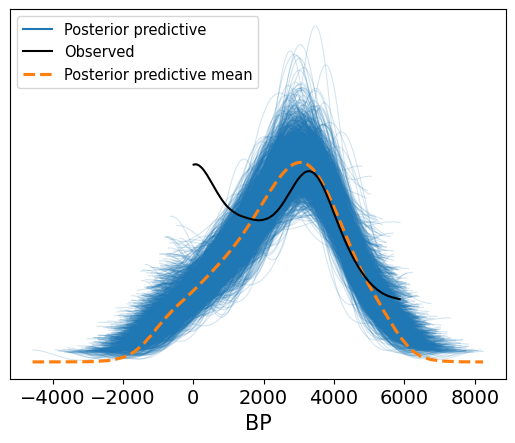

In [ ]:
sam_R6r0 = model_R6r0.predict(dat_R6r0, kind="response")
az.plot_ppc(dat_R6r0)

My final conclusion is that my causal diagram is probably grounded in reality as randomly generated models tried and failed to make a better one, while often being very strongly coupled to `IE`, which I dont think actually makes sense. Additionally, the simpler model that the computer did generate seems to perform similarly but worse than my model, suggesting the number of interactions isnt too high.

## Misc

In [ ]:
u = []
o = []
for elem in ndata:
  if elem['BP'] < 2000:
    u.append(elem)
    print('<2000', elem['Sym'], elem['Ty'])
  else:
    o.append(elem)
    print('>2000', elem['Sym'], elem['Ty'])

<2000 H Diatomics
<2000 He Nobel Gases
<2000 Li Alkali
>2000 Be Alkali
>2000 B Metaloids
>2000 C Non-Metals
<2000 N Diatomics
<2000 O Diatomics
<2000 F Diatomics
<2000 Ne Nobel Gases
<2000 Na Alkali
<2000 Mg Alkali
>2000 Al Metals
>2000 Si Metaloids
<2000 P Non-Metals
<2000 S Non-Metals
<2000 Cl Diatomics
<2000 Ar Nobel Gases
<2000 K Alkali
<2000 Ca Alkali
>2000 Sc Metals
>2000 Ti Metals
>2000 V Metals
>2000 Cr Metals
>2000 Mn Metals
>2000 Fe Metals
>2000 Co Metals
>2000 Ni Metals
>2000 Cu Metals
<2000 Zn Metals
>2000 Ga Metals
>2000 Ge Metaloids
<2000 As Metaloids
<2000 Se Non-Metals
<2000 Br Diatomics
<2000 Kr Nobel Gases
<2000 Rb Alkali
<2000 Sr Alkali
>2000 Y Metals
>2000 Zr Metals
>2000 Nb Metals
>2000 Mo Metals
>2000 Tc Metals
>2000 Ru Metals
>2000 Rh Metals
>2000 Pd Metals
>2000 Ag Metals
<2000 Cd Metals
>2000 In Metals
>2000 Sn Metals
<2000 Sb Metaloids
<2000 Te Metaloids
<2000 I Diatomics
<2000 Xe Nobel Gases
<2000 Cs Alkali
>2000 Ba Alkali
>2000 La Metals
>2000 Ce Metals
>200

In [ ]:
u

[{'Sym': 'H',
  'Ty': 'Diatomics',
  'p': 8.988e-05,
  'M': 1.008,
  'r': 120.0,
  'IE': 13.598,
  'BP': 20.28},
 {'Sym': 'He',
  'Ty': 'Nobel Gases',
  'p': 0.0001785,
  'M': 4.0026,
  'r': 140.0,
  'IE': 24.587,
  'BP': 4.22},
 {'Sym': 'Li',
  'Ty': 'Alkali',
  'p': 0.534,
  'M': 7.0,
  'r': 182.0,
  'IE': 5.392,
  'BP': 1615.0},
 {'Sym': 'N',
  'Ty': 'Diatomics',
  'p': 0.0012506,
  'M': 14.007,
  'r': 155.0,
  'IE': 14.534,
  'BP': 77.36},
 {'Sym': 'O',
  'Ty': 'Diatomics',
  'p': 0.001429,
  'M': 15.999,
  'r': 152.0,
  'IE': 13.618,
  'BP': 90.2},
 {'Sym': 'F',
  'Ty': 'Diatomics',
  'p': 0.001696,
  'M': 18.99840316,
  'r': 135.0,
  'IE': 17.423,
  'BP': 85.03},
 {'Sym': 'Ne',
  'Ty': 'Nobel Gases',
  'p': 0.0008999,
  'M': 20.18,
  'r': 154.0,
  'IE': 21.565,
  'BP': 27.07},
 {'Sym': 'Na',
  'Ty': 'Alkali',
  'p': 0.97,
  'M': 22.9897693,
  'r': 227.0,
  'IE': 5.139,
  'BP': 1156.0},
 {'Sym': 'Mg',
  'Ty': 'Alkali',
  'p': 1.74,
  'M': 24.305,
  'r': 173.0,
  'IE': 7.646,
  'BP

In [ ]:
o

[{'Sym': 'Be',
  'Ty': 'Alkali',
  'p': 1.85,
  'M': 9.012183,
  'r': 153.0,
  'IE': 9.323,
  'BP': 2744.0},
 {'Sym': 'B',
  'Ty': 'Metaloids',
  'p': 2.37,
  'M': 10.81,
  'r': 192.0,
  'IE': 8.298,
  'BP': 4273.0},
 {'Sym': 'C',
  'Ty': 'Non-Metals',
  'p': 2.267,
  'M': 12.011,
  'r': 170.0,
  'IE': 11.26,
  'BP': 4098.0},
 {'Sym': 'Al',
  'Ty': 'Metals',
  'p': 2.7,
  'M': 26.981538,
  'r': 184.0,
  'IE': 5.986,
  'BP': 2792.0},
 {'Sym': 'Si',
  'Ty': 'Metaloids',
  'p': 2.3296,
  'M': 28.085,
  'r': 210.0,
  'IE': 8.152,
  'BP': 3538.0},
 {'Sym': 'Sc',
  'Ty': 'Metals',
  'p': 2.99,
  'M': 44.95591,
  'r': 211.0,
  'IE': 6.561,
  'BP': 3109.0},
 {'Sym': 'Ti',
  'Ty': 'Metals',
  'p': 4.5,
  'M': 47.867,
  'r': 187.0,
  'IE': 6.828,
  'BP': 3560.0},
 {'Sym': 'V',
  'Ty': 'Metals',
  'p': 6.0,
  'M': 50.9415,
  'r': 179.0,
  'IE': 6.746,
  'BP': 3680.0},
 {'Sym': 'Cr',
  'Ty': 'Metals',
  'p': 7.15,
  'M': 51.996,
  'r': 189.0,
  'IE': 6.767,
  'BP': 2944.0},
 {'Sym': 'Mn',
  'Ty': 

Final notes based on the distribution. Since our distribution is bimodal, roughly being divided into Metals and Non-Metals, we see the type parameter being very important, yet because the left maxima is effectively a half normal, and the right mode a full normal, the model struggles to learn it, so we end up with it just giving up on solving for the left mode.

# Conclusion

Key ideas
 * Casual Acrylic Diaphrams very strongly help prodocue models with only variables that logically make sense to learn. No use predicting using variables we as humans know have no relation.
 * We can brute force models, but its not worth the effort and computation time to spends hours running random models when we can spend a little time and get better guesses
 * Interaction terms seem to near or toally universally perform better than heirarchies in this case, and perhaps in other cases as well
 * Most distributions can be broken down into smaller simpler distributions, but sometimes that requires something more complex an a linear normal model.